In [168]:
from google.colab import drive
drive.mount('/content/d')

Drive already mounted at /content/d; to attempt to forcibly remount, call drive.mount("/content/d", force_remount=True).


**The problem set:** In this example I was trying to test if the stock price can be predicted only out of its historical data. The market I considered is MICEX, the stock is Gazprom (blue chip). The task is to:

1. predict the price for the end of the next day (close price)

2. predict upside / downside movement for the end of the next day

To check the time of the cells execution in auto mode I use *ipython-autotime*.

In [169]:
!pip install ipython-autotime
%load_ext autotime

time: 146 µs (started: 2021-05-30 18:01:57 +00:00)


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.layers import SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Bidirectional

time: 5.06 ms (started: 2021-05-30 18:01:57 +00:00)


In [171]:
inputFolder = 'd/My Drive/01_03_nnMicex/input/'

time: 1.06 ms (started: 2021-05-30 18:01:57 +00:00)


In [172]:
!ls 'd/My Drive/01_03_nnMicex/input'

GAZP_130501_190614.csv	GAZP_190617_191023.csv
time: 140 ms (started: 2021-05-30 18:01:57 +00:00)


## Data preparation

As input we have train and validation csv files with 6 years of historical data (min, max, open, close, volume) and 4 months to test the model. The step is one day.

In [173]:
dfTrain = pd.read_csv(inputFolder + 'GAZP_130501_190614.csv', sep=';')
dfTest = pd.read_csv(inputFolder + 'GAZP_190617_191023.csv', sep=';')

print(dfTrain.info())
dfTrain.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  1540 non-null   object 
 1   <PER>     1540 non-null   object 
 2   <DATE>    1540 non-null   int64  
 3   <TIME>    1540 non-null   int64  
 4   <OPEN>    1540 non-null   float64
 5   <HIGH>    1540 non-null   float64
 6   <LOW>     1540 non-null   float64
 7   <CLOSE>   1540 non-null   float64
 8   <VOL>     1540 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 108.4+ KB
None


,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,20130502,0,122.96,124.04,122.55,122.96,12487110
1,GAZP,D,20130503,0,123.69,128.75,123.45,128.70,30425410


time: 37.3 ms (started: 2021-05-30 18:01:58 +00:00)


As the first steps we convert the date to *datetime* stamp and drop non-informative columns:

In [174]:
# converting to datetime
dfTrain['dtime'] = pd.to_datetime(dfTrain['<DATE>'], format='%Y%m%d')
dfTest['dtime'] = pd.to_datetime(dfTest['<DATE>'], format='%Y%m%d')
# setting dime index
dfTrain['dtime'] = pd.to_datetime(dfTrain['<DATE>'], format='%Y%m%d')
dfTest['dtime'] = pd.to_datetime(dfTest['<DATE>'], format='%Y%m%d')
# dropping non-feature columns
dfTrain = dfTrain.drop(columns=['<TICKER>', '<PER>', '<DATE>', '<TIME>'], axis=1)
dfTest = dfTest.drop(columns=['<TICKER>', '<PER>', '<DATE>', '<TIME>'], axis=1)
# setting index to datetime
dfTrain = dfTrain.set_index('dtime')
dfTest = dfTest.set_index('dtime')

dfTrain.head(2)

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
dtime,,,,,
2013-05-02,122.96,124.04,122.55,122.96,12487110
2013-05-03,123.69,128.75,123.45,128.70,30425410


time: 27.6 ms (started: 2021-05-30 18:01:58 +00:00)


In [175]:
def consistCheck(df):
    print(f'nulls: {sum([df[col].isnull().sum() for col in df.columns])}')
    print(f'unique dates vs all values: {df.index.unique().shape[0]} / {df.shape[0]}')

print('train sample:')
consistCheck(dfTrain)
print('\ntest sample:')
consistCheck(dfTest)

train sample:
nulls: 0
unique dates vs all values: 1540 / 1540

test sample:
nulls: 0
unique dates vs all values: 93 / 93
time: 8.78 ms (started: 2021-05-30 18:01:58 +00:00)


Having confirmed that the input is correct let's plot it:

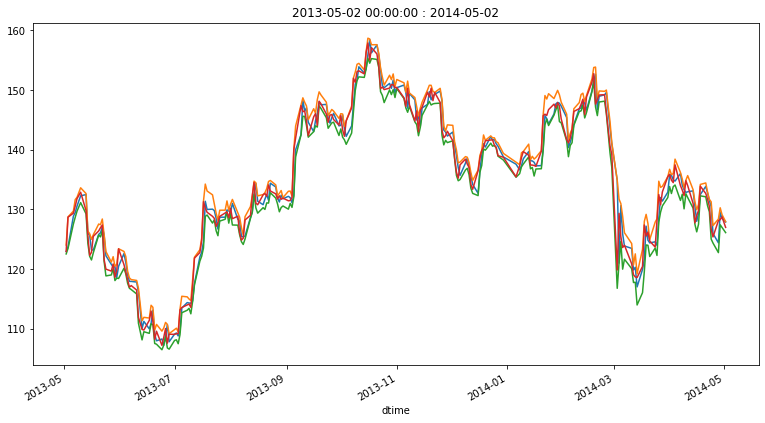

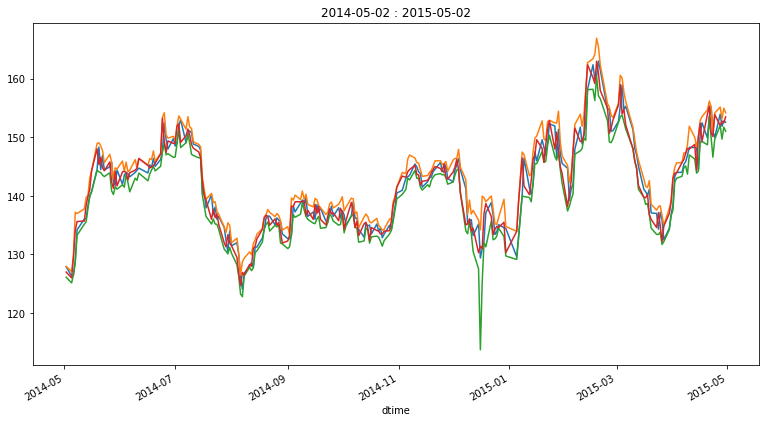

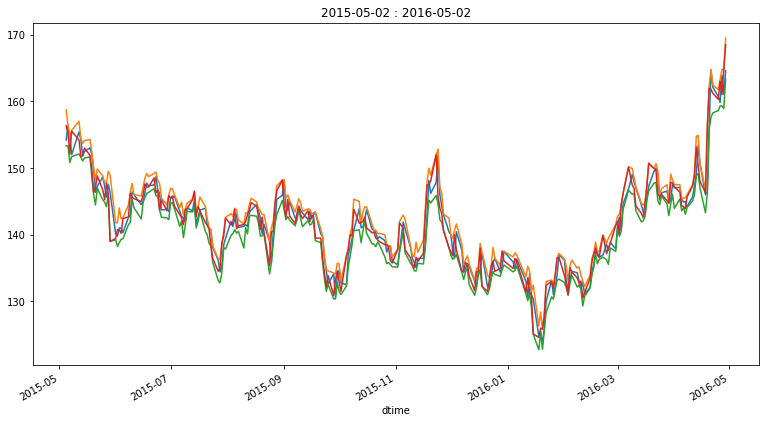

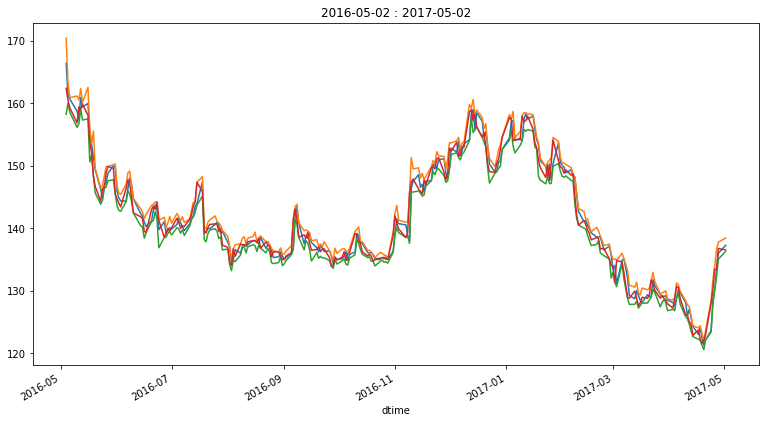

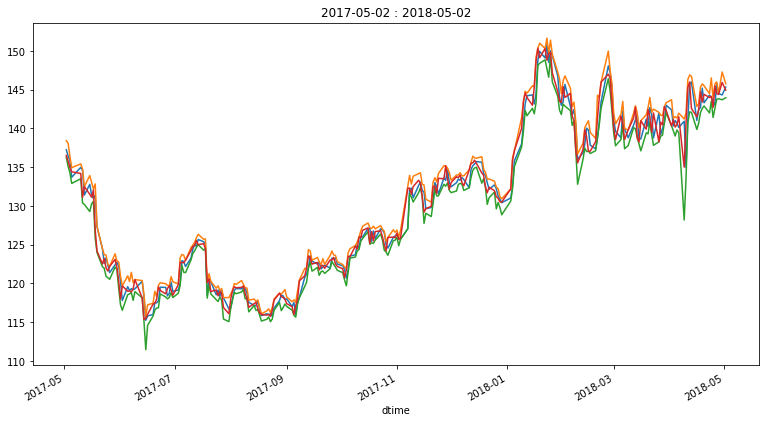

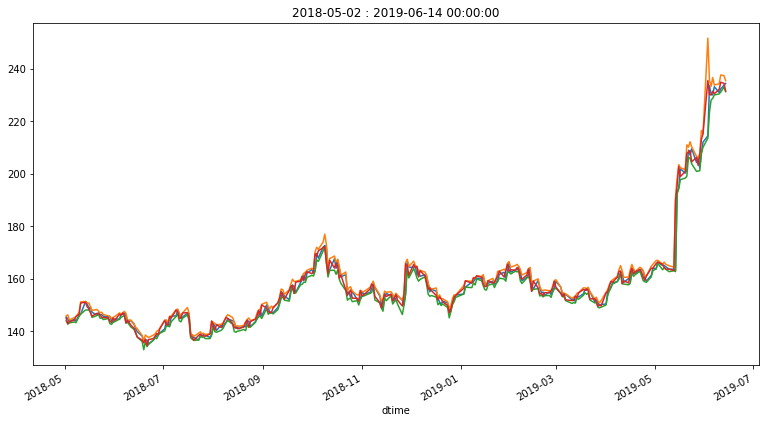

time: 1.63 s (started: 2021-05-30 18:01:58 +00:00)


In [176]:
def plotPrice(df, beg, end):
    '''plotting eithor the whole or
    the defined period'''
    for col in df.columns[:-1]:
        df[col][beg:end].plot(
            style='-',
            figsize=(13,7),
            title=f'{beg} : {end}'
        )

periods = [dfTrain.index[0], '2014-05-02', '2015-05-02', '2016-05-02',
           '2017-05-02', '2018-05-02', dfTrain.index[-1]]

for i in range(len(periods)-1):
    plotPrice(dfTrain, periods[i], periods[i+1])
    plt.show()

# plotPrice(dfTrain)

Now let's extract the extra features (year, day of a week, month, etc) from the date itself:

In [177]:
def dateFeat(df):
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayOfYear'] = df.index.dayofyear
    df['dayOfMonth'] = df.index.day
    df['weekOfYear'] = df.index.isocalendar().week
    df['dayOfWeek'] = df.index.dayofweek

    return df

dfTrain = dateFeat(dfTrain)
dfTest = dateFeat(dfTest)

time: 27.2 ms (started: 2021-05-30 18:01:59 +00:00)


We try to generate some more features by shifting close date for **h** days and taking first difference with the original series.

In [178]:
def shiftAdd(df, col, h):
    '''
    shifting series of a column
    to h periods ahead & taking 1st diff
    '''
    colDf = pd.DataFrame(df[clm], index=df.index)
    for i in range(1, h+1):
        colDf[f't{i}'] = 0.0 # init cols for the shifted values
        colDf.iloc[i:, i] = colDf.iloc[:-i, 0].values # shift values

    # adding diff-s
    colDf['diff1'] = 0.0
    for i in range(colDf.shape[0]-1):
        colDf['diff1'][i] = colDf.iloc[:-1,0][i] - colDf.iloc[1:,0][i]

    # merge all the new features
    newDf = pd.merge(
        colDf.reset_index(),
        df.reset_index(),
        how='left'
    ).set_index(colDf.index)
    newDf = newDf.drop(columns=['dtime'], axis=1)
    
    print(newDf.shape)

    return newDf

dfTrain = shiftAdd(dfTrain, '<CLOSE>', 5)
dfTest = shiftAdd(dfTest, '<CLOSE>', 5)

(1540, 18)
(93, 18)
time: 623 ms (started: 2021-05-30 18:01:59 +00:00)


In [179]:
dfTrain.head(2)

,<VOL>,t1,t2,t3,t4,t5,diff1,<OPEN>,<HIGH>,<LOW>,<CLOSE>,year,quarter,month,dayOfYear,dayOfMonth,weekOfYear,dayOfWeek
dtime,,,,,,,,,,,,,,,,,,
2013-05-02,12487110,0.0,0.0,0.0,0.0,0.0,-17938300.0,122.96,124.04,122.55,122.96,2013,2,5,122,2,18,3
2013-05-03,30425410,12487110.0,0.0,0.0,0.0,0.0,6658620.0,123.69,128.75,123.45,128.70,2013,2,5,123,3,18,4


time: 35.1 ms (started: 2021-05-30 18:02:00 +00:00)


Now we are ready to split our train data for the train and validation samples. Let's take one last year of the train data for the validation sample.

In [180]:
def splitDf(df, split_date):
    return df.loc[df.index <= split_date].copy(), \
           df.loc[df.index >  split_date].copy()

trainSamp, valSamp = splitDf(dfTrain, '2018-06-14')

time: 5.2 ms (started: 2021-05-30 18:02:00 +00:00)


We can also plot the samples for a visual check.

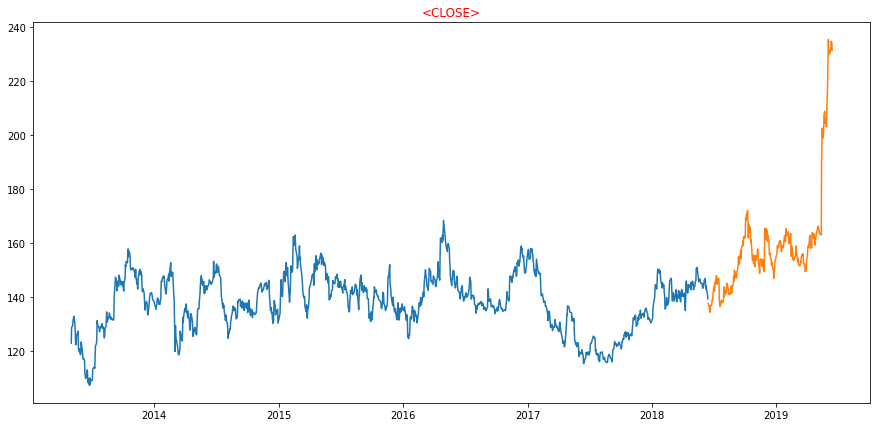

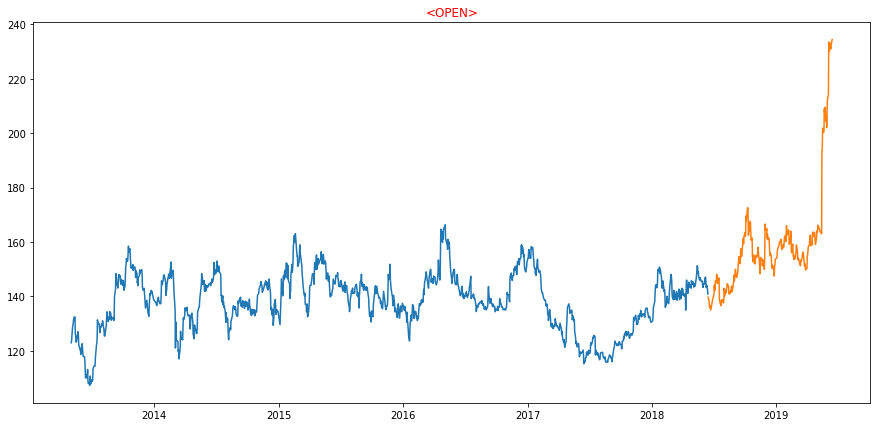

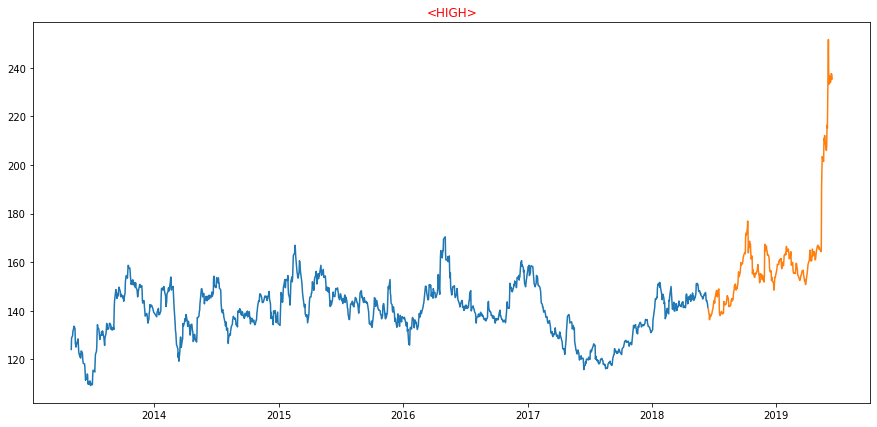

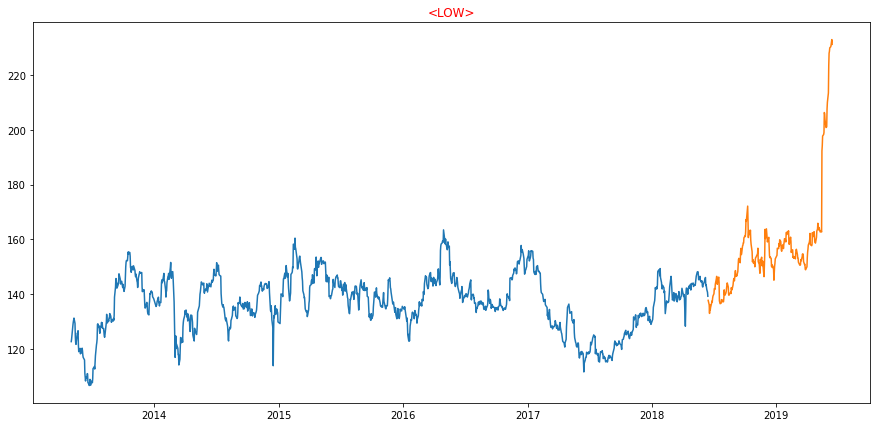

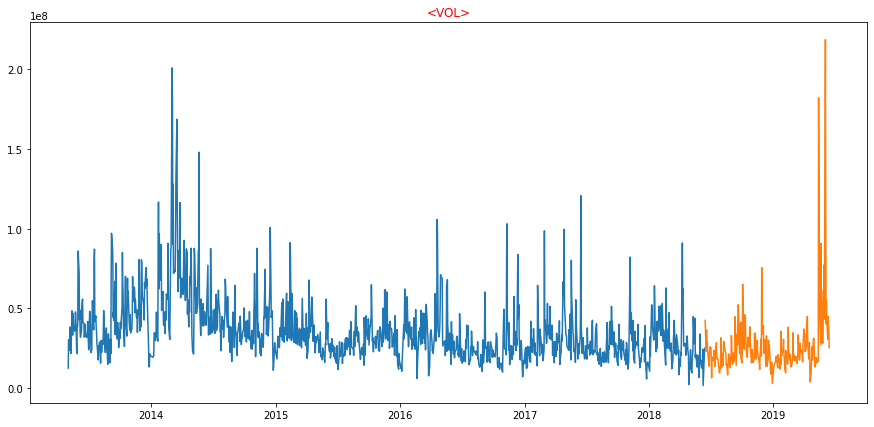

time: 799 ms (started: 2021-05-30 18:02:00 +00:00)


In [181]:
clmsToVis = ['<CLOSE>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>']
for clm in clmsToVis:
    plt.figure(figsize=(15,7))
    plt.plot(trainSamp.index, trainSamp[clm], label='Train')
    plt.plot(valSamp.index, valSamp[clm], label='Validation')
    plt.title(clm, color='r')
    plt.show()

After that we are ready to state the target (close price) and scale the sample values that are passed to the neural net.

In [182]:
# extract target
yTrain = trainSamp['<CLOSE>'].values
xTrain = trainSamp.drop(columns='<CLOSE>')
yVal = valSamp['<CLOSE>'].values
xVal = valSamp.drop(columns='<CLOSE>')

# scale
scaler = MinMaxScaler(feature_range=(0,1))
xTrain = scaler.fit_transform(xTrain)
xVal = scaler.fit_transform(xVal)

# prep the samples fo the input to the recurrent nn 
xTrainLstm = xTrain.reshape(xTrain.shape[0], 1, xTrain.shape[1])
xValLstm = xVal.reshape(xVal.shape[0], 1, xVal.shape[1])

time: 23 ms (started: 2021-05-30 18:02:01 +00:00)


## Fit the model

To predict the price we can use different models structures. Let's try and validate the score.

The first one will be [Long Short Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) RNN with *mean squarred error* as the loss function and metrics. We have 150 neurons LSTM layer and 1 neuron dense output layer.

Epoch 1/10
41/41 [==============================] - 1s 9ms/step - loss: 19068.9121 - mse: 19068.9121 - val_loss: 25513.8301 - val_mse: 25513.8301
Epoch 2/10
41/41 [==============================] - 0s 5ms/step - loss: 18464.5078 - mse: 18464.5078 - val_loss: 24495.9727 - val_mse: 24495.9727
Epoch 3/10
41/41 [==============================] - 0s 5ms/step - loss: 16696.1777 - mse: 16696.1777 - val_loss: 22051.4961 - val_mse: 22051.4961
Epoch 4/10
41/41 [==============================] - 0s 5ms/step - loss: 13350.5342 - mse: 13350.5342 - val_loss: 18084.2656 - val_mse: 18084.2656
Epoch 5/10
41/41 [==============================] - 0s 5ms/step - loss: 9065.7236 - mse: 9065.7236 - val_loss: 13442.6631 - val_mse: 13442.6631
Epoch 6/10
41/41 [==============================] - 0s 5ms/step - loss: 5147.2910 - mse: 5147.2910 - val_loss: 9286.2217 - val_mse: 9286.2217
Epoch 7/10
41/41 [==============================] - 0s 5ms/step - loss: 2521.8950 - mse: 2521.8950 - val_loss: 6333.3896 - val_mse

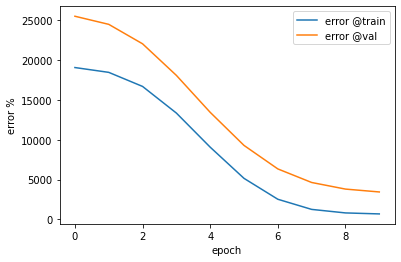

the validation score: 3439.32275390625
time: 3.73 s (started: 2021-05-30 18:02:01 +00:00)


In [183]:
model = Sequential()

model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(
    xTrainLstm, yTrain,
    epochs=10,
    validation_data=(xValLstm, yVal),
    shuffle=False,
)

plt.plot(history.history['mse'], label='error @train')
plt.plot(history.history['val_mse'], label='error @val')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.legend()
plt.show()

print(f"the validation score: {history.history['val_mse'][-1]}")

Now we add *BatchNormalization* and *Dropout* layers.

Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

Dropout randomly zeros some of the incoming layers.

Epoch 1/10
41/41 [==============================] - 2s 12ms/step - loss: 18861.5957 - mse: 18861.5957 - val_loss: 25216.0547 - val_mse: 25216.0547
Epoch 2/10
41/41 [==============================] - 0s 5ms/step - loss: 16487.0664 - mse: 16487.0664 - val_loss: 21897.1953 - val_mse: 21897.1953
Epoch 3/10
41/41 [==============================] - 0s 5ms/step - loss: 9802.8975 - mse: 9802.8975 - val_loss: 14127.9287 - val_mse: 14127.9287
Epoch 4/10
41/41 [==============================] - 0s 5ms/step - loss: 3349.1045 - mse: 3349.1045 - val_loss: 8957.8682 - val_mse: 8957.8682
Epoch 5/10
41/41 [==============================] - 0s 5ms/step - loss: 1053.6407 - mse: 1053.6407 - val_loss: 6119.7988 - val_mse: 6119.7988
Epoch 6/10
41/41 [==============================] - 0s 6ms/step - loss: 504.7396 - mse: 504.7396 - val_loss: 3929.8667 - val_mse: 3929.8667
Epoch 7/10
41/41 [==============================] - 0s 5ms/step - loss: 311.8944 - mse: 311.8944 - val_loss: 2967.5833 - val_mse: 2967.5833

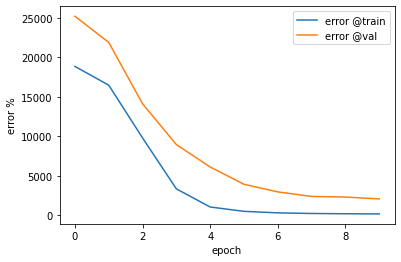

the validation score: 2079.00830078125
time: 3.91 s (started: 2021-05-30 18:02:05 +00:00)


In [184]:
model = Sequential()

model.add(LSTM(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(
    xTrainLstm, yTrain,
    epochs=10,
    validation_data=(xValLstm, yVal),
    shuffle=False,
)

plt.plot(history.history['mse'], label='error @train')
plt.plot(history.history['val_mse'], label='error @val')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.legend()
plt.show()

print(f"the validation score: {history.history['val_mse'][-1]}")

The result is much better score. So let's use this model.

In [185]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 150)               100800    
_________________________________________________________________
batch_normalization_13 (Batc (None, 150)               600       
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 116,601
Trainable params: 116,301
Non-trainable params: 300
_________________________________________________________________
None
time: 3.85 ms (started: 2021-05-30 18:02:09 +00:00)


## Test the model
The final step is to test the model for the left-off sample of 4 latter months. To do that we need preprocess the sample for the model input and then predict:

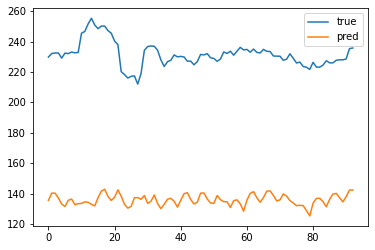

time: 326 ms (started: 2021-05-30 18:02:09 +00:00)


In [186]:
# extract target
yTest = dfTest['<CLOSE>'].values
xTest = dfTest.drop(columns='<CLOSE>')

# scale
# scaler = MinMaxScaler(feature_range=(0,1))
xTest = scaler.transform(xTest)

# prep the samples fo the input to the recurrent nn 
xTestLstm = xTest.reshape(xTest.shape[0], 1, xTest.shape[1])

# predicting for test 
yPredRaw = model.predict(xTestLstm)

# plotting prediction
plt.plot(yTest, label='true')
plt.plot(yPredRaw, label='pred')
plt.legend()
plt.show()

In [187]:
print(f'mse: {mean_squared_error(y_true=yTest, y_pred=yPredRaw)}')

mse: 9201.69302774703
time: 1.23 ms (started: 2021-05-30 18:02:09 +00:00)


In [188]:
# true vs prediction comparison
print(pd.concat(
    (pd.DataFrame(yPredRaw, columns=['pred']), 
     pd.DataFrame(yTest, columns=['true'])
    ), 
    axis=1)[:10])

         pred    true
0  135.504105  229.81
1  140.272156  232.13
2  140.242126  232.46
3  137.053635  232.52
4  133.086639  229.09
5  131.437241  232.38
6  135.540268  232.09
7  136.333267  233.10
8  132.676147  232.60
9  133.356491  232.83
time: 8.69 ms (started: 2021-05-30 18:02:09 +00:00)


Obviously the prediction turns out to be lower than the true value (probably because of the intense upside trend. Let's check can we at least predict the direction of the stock movement if compared today end vs tomorrow end.

In [189]:
pd.options.mode.chained_assignment = None 

# checking direction 
cmpr = pd.concat(
    (pd.DataFrame(yTest, columns=['true'], index=dfTest.index),
    pd.DataFrame(yPredRaw, columns=['pred'], index=dfTest.index)),
    axis=1
)

cmpr['dir_true'] = np.zeros(cmpr.shape[0])
cmpr['dir_pred'] = np.zeros(cmpr.shape[0])
cmpr['corr_dir'] = np.zeros(cmpr.shape[0])
cmpr['dir_true'][0] = 0
cmpr['dir_pred'][0] = 0

for i in range(1, cmpr.shape[0]):
    cmpr['dir_true'][i] = cmpr['true'][i] - cmpr['true'][i-1]
    cmpr['dir_pred'][i] = cmpr['pred'][i] - cmpr['pred'][i-1]
    if np.sign(cmpr['dir_true'][i]) == np.sign(cmpr['dir_pred'][i]):
        cmpr['corr_dir'][i] = 1
    else: 
        cmpr['corr_dir'][i] = 0
        
print(
    f'================================================\n'
    f'the share of the correct preidctions is '
    f'{round(cmpr.corr_dir.sum() / cmpr.corr_dir.shape[0]* 100, 2)} %\n'
    f'================================================\n'
)

the share of the correct preidctions is 54.84 %

time: 44.7 ms (started: 2021-05-30 18:02:09 +00:00)


In the case the prediction only out of the price history is no better than the coin toss. The further research might be continued with:

* more data re world market indices and other stocks 
* dynamic data about the company fundamential factors (revenue, costs, number of employees, etc)
* text parsing of the the news that might contain triggers for the price direction 